In [3]:
import pandas as pd
import seaborn as sns
import requests
import re
import matplotlib.pyplot as plt 
from nltk.tokenize import RegexpTokenizer
from  nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import numpy as np


from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report





In [4]:
df1 = pd.read_csv("twitter_new.csv", encoding='latin-1', names=["target","id", "date", "flag","user","text"])
df1.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## checking for missing data

In [5]:
df1.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

## EDA

In [6]:
df1.shape

(1600000, 6)

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
df1["target"].nunique()

2

In [9]:
df1["target"].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

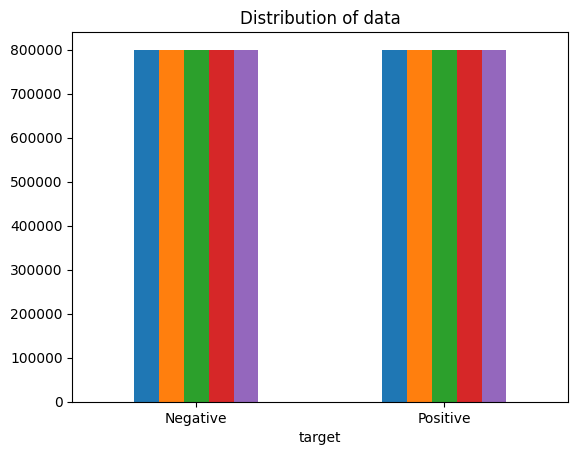

In [10]:
# Plotting the distribution for dataset.
ax = df1.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df1['text']), list(df1['target'])

Data preprocessing

In [11]:
df2=df1[['text','target']]

In [12]:
df2['target'] = df2['target'].replace(4,1)

/var/folders/bg/499n_msn3n16bxgl_zjn3dvr0000gp/T/ipykernel_1435/3826860475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['target'] = df2['target'].replace(4,1)


In [13]:
## Taking 1/4th of the data so that we run it easily in our ML model

### For that we need to separate the data based on class

data_pos = df2[df2['target'] == 1]
data_neg = df2[df2['target'] == 0]


In [14]:
data_pos = data_pos.iloc[:int(200000)]
data_neg = data_neg.iloc[:int(200000)]

In [15]:
data_pos.shape, data_neg.shape

((200000, 2), (200000, 2))

In [16]:
df3 = pd.concat([data_pos, data_neg])
df3.shape

(400000, 2)

In [17]:
## Making the text of the 

df3["text"] = df3["text"].str.lower()
df3["text"]

800000         i love @health4uandpets u guys r the best!! 
800001    im meeting up with one of my besties tonight! ...
800002    @darealsunisakim thanks for the twitter add, s...
800003    being sick can be really cheap when it hurts t...
800004      @lovesbrooklyn2 he has that effect on everyone 
                                ...                        
199995                                  doesn't feel good. 
199996                                       work... again 
199997    @damienfranco its so common for it to crash no...
199998            my baby boy is wearing big boy underwear 
199999               fml! i forgot my phone charger @home! 
Name: text, Length: 400000, dtype: object

In [18]:


url = "https://gist.githubusercontent.com/ZohebAbai/513218c3468130eacff6481f424e4e64/raw/b70776f341a148293ff277afa0d0302c8c38f7e2/gist_stopwords.txt"

response = requests.get(url)
if response.status_code == 200:
    stopwords_list = response.text.split(",")
    # You can use stopwords here in your code
else:
    print("Failed to retrieve stopwords file.")


In [19]:
stopwords = set(stopwords_list)


### defining function to removing the stopwords from the text
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords])


In [20]:
df3["text"] = df3["text"].apply(cleaning_stopwords)
df3.head()

,text,target
800000,love @health4uandpets guys best!!,1
800001,meeting besties tonight! wait!! - girl talk!!,1
800002,"@darealsunisakim twitter add, sunisa! meet hin...",1
800003,"sick cheap hurts eat real food plus, friends soup",1
800004,@lovesbrooklyn2,1


In [21]:
### defining function to remove punctuation from the text
import string
punctuations_list = string.punctuation


def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [22]:
df3["text"] = df3["text"].apply(cleaning_punctuations)
df3.tail()

,text,target
199995,feel good,0
199996,work,0
199997,damienfranco common crash delete process eatin...,0
199998,baby boy wearing big boy underwear,0
199999,fml forgot phone charger home,0


In [23]:
# ### defining fucntion to remove repeating character from text
# import re
# def cleaning_repeating_char(text):
#     return re.sub(r'(.)1+', r'1', text)

In [24]:
# df3["text"] = df3["text"].apply(cleaning_repeating_char)
# df3.head()

In [25]:
## defining function to remove URLs from the text

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

In [26]:
df3["text"] = df3["text"].apply(cleaning_URLs)


In [27]:
# defining function to remove numeric characters from text

def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)


In [28]:
df3["text"] = df3["text"].apply(cleaning_numbers)
df3.head()

,text,target
800000,love healthuandpets guys best,1
800001,meeting besties tonight wait girl talk,1
800002,darealsunisakim twitter add sunisa meet hin ar...,1
800003,sick cheap hurts eat real food plus friends soup,1
800004,lovesbrooklyn,1


In [29]:
# tokenized_tweet = df3['text'].apply(lambda x: x.split())
# tokenized_tweet.head()

In [30]:
tokenizer = RegexpTokenizer(r'\w+')
df3['text'] = df3['text'].apply(tokenizer.tokenize)
df3['text'].head()

800000                   [love, healthuandpets, guys, best]
800001        [meeting, besties, tonight, wait, girl, talk]
800002    [darealsunisakim, twitter, add, sunisa, meet, ...
800003    [sick, cheap, hurts, eat, real, food, plus, fr...
800004                                      [lovesbrooklyn]
Name: text, dtype: object

In [31]:
df3.tail()

,text,target
199995,"[feel, good]",0
199996,[work],0
199997,"[damienfranco, common, crash, delete, process,...",0
199998,"[baby, boy, wearing, big, boy, underwear]",0
199999,"[fml, forgot, phone, charger, home]",0


In [32]:
## steming
st = PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data


In [33]:
df3['text']= df3['text'].apply(lambda x: stemming_on_text(x))
df3['text'].tail()

199995                                         [feel, good]
199996                                               [work]
199997    [damienfranco, common, crash, delete, process,...
199998            [baby, boy, wearing, big, boy, underwear]
199999                  [fml, forgot, phone, charger, home]
Name: text, dtype: object

In [34]:
import nltk
import os
from nltk.stem import WordNetLemmatizer
import ssl

# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Initialize WordNetLemmatizer
lm = WordNetLemmatizer()

# Define function for lemmatization
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

# Apply lemmatization to 'text' column of DataFrame df3
df3['text'] = df3['text'].apply(lambda x: lemmatizer_on_text(x))

# Display the lemmatized 'text' column
print(df3['text'].tail())


199995                                         [feel, good]
199996                                               [work]
199997    [damienfranco, common, crash, delete, process,...
199998            [baby, boy, wearing, big, boy, underwear]
199999                  [fml, forgot, phone, charger, home]
Name: text, dtype: object


In [35]:
df3["text"] = df3["text"].apply(lambda x: ' '.join(x))
df3.tail()

,text,target
199995,feel good,0
199996,work,0
199997,damienfranco common crash delete process eatin...,0
199998,baby boy wearing big boy underwear,0
199999,fml forgot phone charger home,0


In [36]:
# Separating input and output feature

X=df3.text
y=df3.target

In [37]:
df3.shape

(400000, 2)

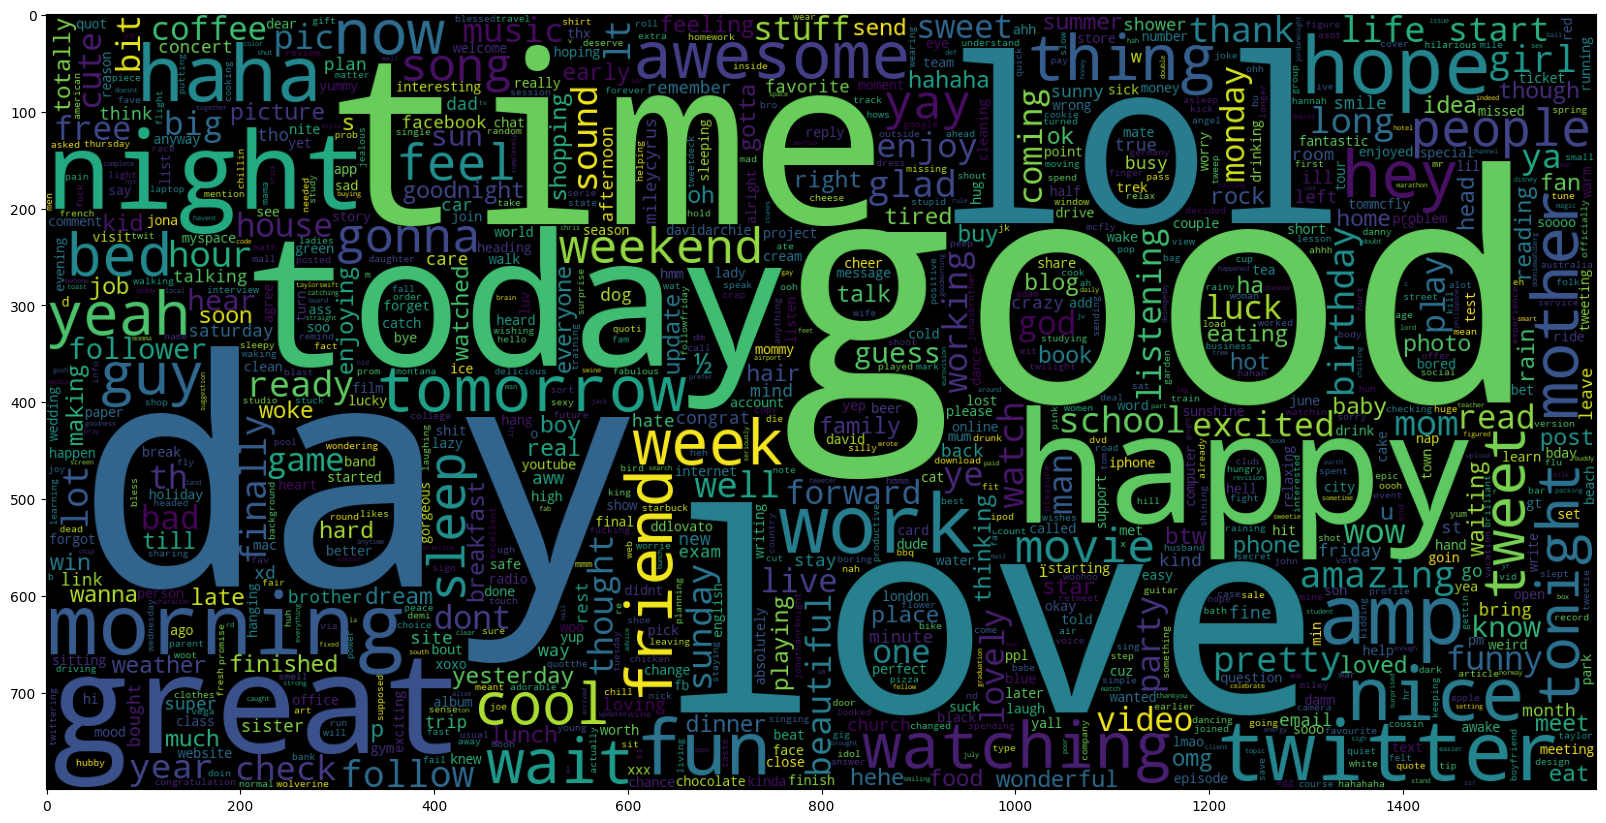

In [38]:
### Word cloud plotting for positive words

data_pos = df3[df3["target"] == 1]
text_data = ' '.join(data_pos['text'])
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(text_data)
plt.figure(figsize = (20,20))
plt.imshow(wc)

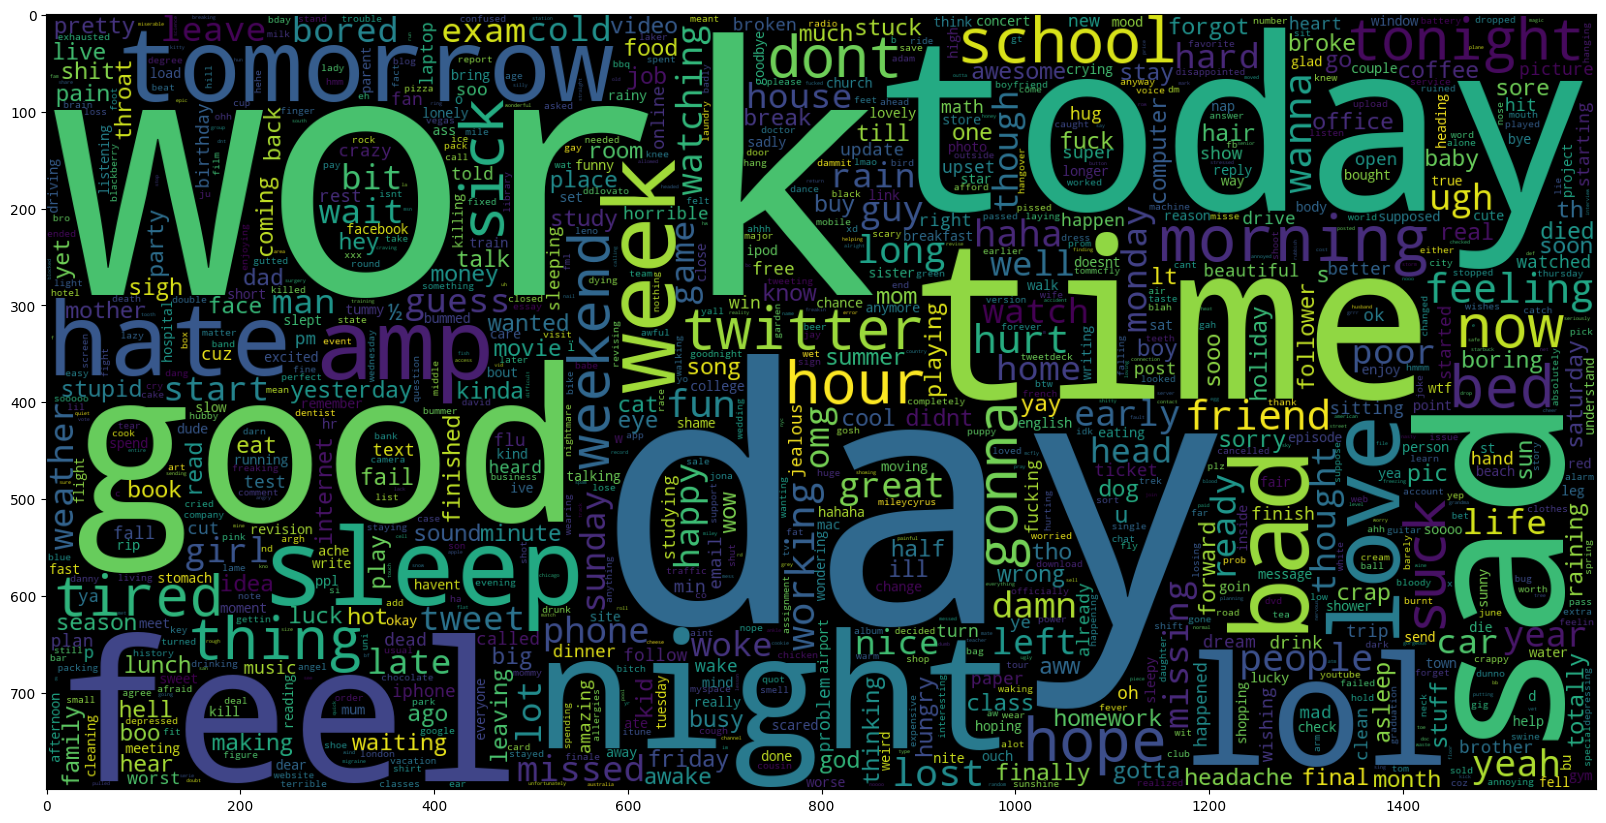

In [39]:
## Word cloud plotting for negatice words

data_neg = df3[df3["target"] == 0]
text_data = ' '.join(data_neg['text'])
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(text_data)
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)


In [41]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [42]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [43]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### BernoulliNB

              precision    recall  f1-score   support

           0       0.74      0.76      0.75     10070
           1       0.75      0.73      0.74      9930

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



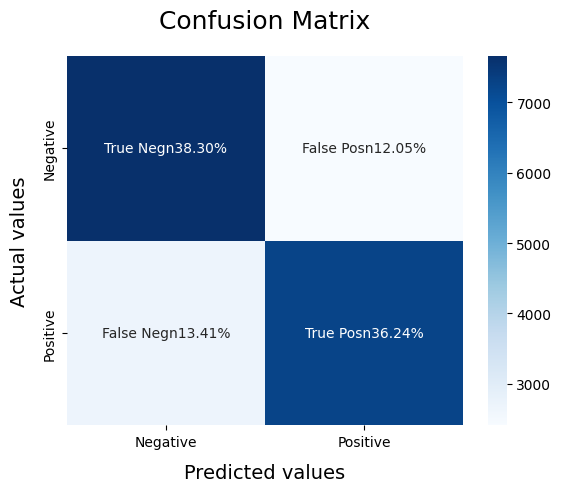

In [44]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

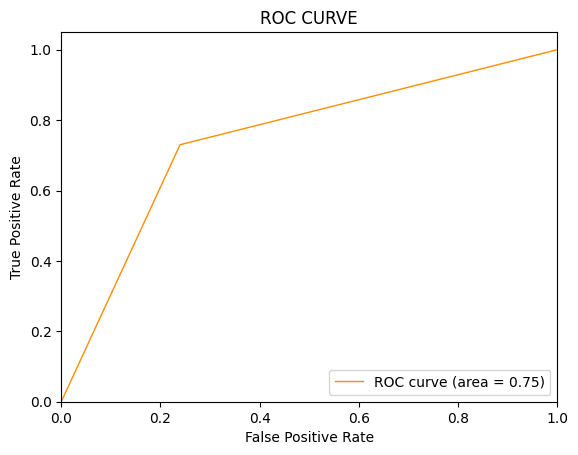

In [45]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### LinearSVC

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.75      0.73      0.74     10070
           1       0.73      0.75      0.74      9930

    accuracy                           0.74     20000
   macro avg       0.74      0.74      0.74     20000
weighted avg       0.74      0.74      0.74     20000



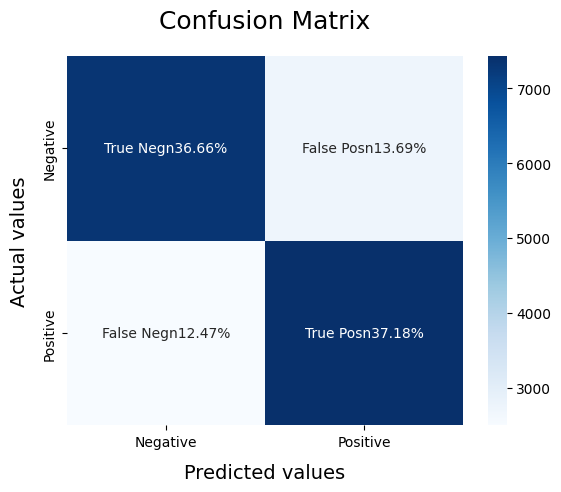

In [46]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

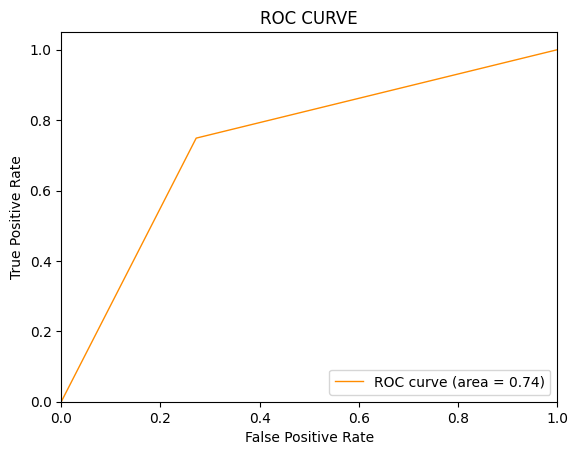

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### LogisticRegression

              precision    recall  f1-score   support

           0       0.76      0.73      0.75     10070
           1       0.74      0.77      0.75      9930

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



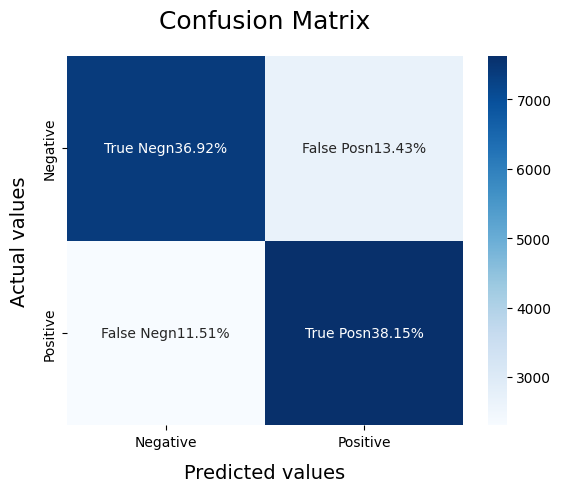

In [48]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

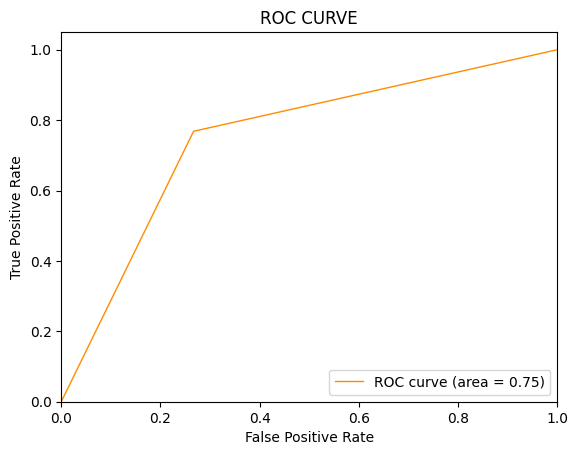

In [49]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [107]:
def call_func(text):
    text_series = pd.Series([text])
    text_series_lower = text_series.str.lower()
    op1 = text_series_lower.apply(cleaning_stopwords)
    op1 = op1.apply(cleaning_punctuations)
    op1 = op1.apply(cleaning_numbers)
    op1 = op1.apply(cleaning_URLs)
    tokens = op1.apply(tokenizer.tokenize)
    stem = tokens.apply(stemming_on_text)
    lemma = stem.apply(lemmatizer_on_text)
    final = lemma.apply(lambda x: " ".join(x))
    final_text = vectoriser.transform(final)
    pred = LRmodel.predict(final_text)
    return pred

In [108]:
call_func(" Haertfull of thanks to you 3rbk35 my love")

array([1])